In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
        print(os.path.join(dirname))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/config4
/kaggle/input/config2
/kaggle/input/microsoft-catsvsdogs-dataset
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat
/kaggle/input/config3


In [3]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import yaml

{'Cat': 12501, 'Dog': 12501}


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


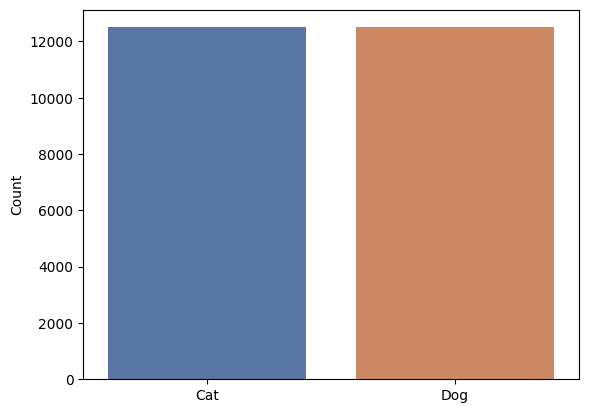

In [4]:
root_directory = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages'
cls_name=['Cat','Dog' ]
data = {n: len(os.listdir(os.path.join(root_directory, n))) for n in cls_name}
print(data)

sns.barplot(x=list(data.keys()), y=list(data.values()),palette="deep")
plt.ylabel('Count')
plt.show()

In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create the dataset
dataset = datasets.ImageFolder(root_directory, transform=transform)

# Filter out images you want to exclude
filtered_indices = []
def meets_criteria(img_path):
    files_to_exclude = ['666.jpg','11702.jpg']
    
    # Get the base name of the image path (i.e., the file name)
    img_filename = os.path.basename(img_path) 
    # Check if the image filename is not in the list of files to exclude
    return img_filename not in files_to_exclude

for idx, (img_path, label) in enumerate(dataset.samples):
    # Example: Exclude images with specific conditions
    if meets_criteria(img_path):
        filtered_indices.append(idx)

# Exclude filtered indices from the dataset
filtered_dataset = torch.utils.data.Subset(dataset, indices=filtered_indices)

# Specify the split ratios
train_ratio = 0.7
test_ratio = 0.15
val_ratio = 0.15

# Calculate the number of samples for each split
num_samples = len(filtered_dataset)
num_train = int(train_ratio * num_samples)
num_test = int(test_ratio * num_samples)
num_val = num_samples - num_train - num_test

# Use random_split to split the filtered dataset
train_data, test_val_data = random_split(filtered_dataset, [num_train, num_test + num_val])
test_data, val_data = random_split(test_val_data, [num_test, num_val])

def load_data(batch_size):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    return train_loader,test_loader,val_loader

In [6]:
# def show_images(images, labels):
#     plt.figure(figsize=(20, 10))
#     num_images = len(images)
    
#     for i in range(num_images):
#         plt.subplot(int(num_images/8),8, i + 1)
#         plt.imshow(np.transpose(images[i], (1, 2, 0)))
#         plt.title(f"Label: {cls_name[labels[i]]}")
#         plt.axis('off')
    
#     plt.show()

# for batch, (X_train, y_train) in enumerate(train_loader):
#     break

# show_images(X_train, y_train)

In [7]:
# X_train.shape, y_train.shape

In [8]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

class SimpleCNN(nn.Module):
    def __init__(self, activation_function):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            nn.Flatten()
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(200704, 128),
            getattr(nn, activation_function)(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 128),
            getattr(nn, activation_function)(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
def train_model(config_path):
    # Load YAML configuration
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)

    # Extract parameters
    batch_size = config["model"]["batch_size"]
#     num_epochs = config["model"]["epoch"]
    num_epochs = 30
    activation_function = config["model"]["activation_function"]
    loss_function = config["model"]["loss_function"]
    optimizer_type = config["model"]["optimizer"]["type"]
    learning_rate = config["model"]["optimizer"]["learning_rate"]
    weight_decay = config["model"]["optimizer"]["weight_decay"]

    # Load data
    train_loader, test_loader, val_loader = load_data(batch_size)

    # Initialize model and optimizer
    model = SimpleCNN(activation_function).to(device)
    criterion = getattr(nn, loss_function)()
    optimizer = getattr(optim, optimizer_type)(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        correct_train = 0
        total = 0

        # Initialize running loss as a tensor with zero value
        running_loss = torch.zeros(1, device=device, requires_grad=True)

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted_train = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

            # Update the running loss using the tensor addition with detached tensor
            running_loss = running_loss + loss

            loss.backward()
            optimizer.step()

        avg_loss = running_loss.item() / len(train_loader)
        train_losses.append(avg_loss)

        train_accuracy = correct_train / total
        train_accuracies.append(train_accuracy)

        model.eval()
        correct_val = 0
        total_val = 0

        # Initialize validation running loss as a tensor with zero value
        val_running_loss = torch.zeros(1, device=device, requires_grad=False)

        with torch.no_grad():
            for inputs_val, labels_val in val_loader:
                inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
                outputs_val = model(inputs_val)
                val_loss = criterion(outputs_val, labels_val)
                _, predicted_val = torch.max(outputs_val.data, 1)
                total_val += labels_val.size(0)
                correct_val += (predicted_val == labels_val).sum().item()

                # Update the validation running loss using the tensor addition with detached tensor
                val_running_loss = val_running_loss.detach() + val_loss

            val_avg_loss = val_running_loss.item() / len(val_loader)
            val_losses.append(val_avg_loss)

            val_accuracy = correct_val / total_val
            val_accuracies.append(val_accuracy)
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Validation Loss: {val_avg_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%, Validation Accuracy: {val_accuracy * 100:.2f}%')

    plt.figure(figsize=(10, 5)) 
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    return model

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch [1/30], Train Loss: 0.7152, Validation Loss: 0.6938, Train Accuracy: 50.37%, Validation Accuracy: 49.81%
Epoch [2/30], Train Loss: 0.6989, Validation Loss: 0.6933, Train Accuracy: 49.99%, Validation Accuracy: 50.19%
Epoch [3/30], Train Loss: 0.6959, Validation Loss: 0.6903, Train Accuracy: 50.40%, Validation Accuracy: 53.49%
Epoch [4/30], Train Loss: 0.6898, Validation Loss: 0.6783, Train Accuracy: 53.78%, Validation Accuracy: 57.15%
Epoch [5/30], Train Loss: 0.6813, Validation Loss: 0.6861, Train Accuracy: 57.06%, Validation Accuracy: 55.68%
Epoch [6/30], Train Loss: 0.6736, Validation Loss: 0.6603, Train Accuracy: 57.63%, Validation Accuracy: 60.40%
Epoch [7/30], Train Loss: 0.6686, Validation Loss: 0.6490, Train Accuracy: 58.02%, Validation Accuracy: 60.61%
Epoch [8/30], Train Loss: 0.6630, Validation Loss: 0.7091, Train Accuracy: 59.34%, Validation Accuracy: 55.79%
Epoch [9/30], Train Loss: 0.6496, Validation Loss: 0.6775, Train Accuracy: 61.55%, Validation Accuracy: 59.60%
E

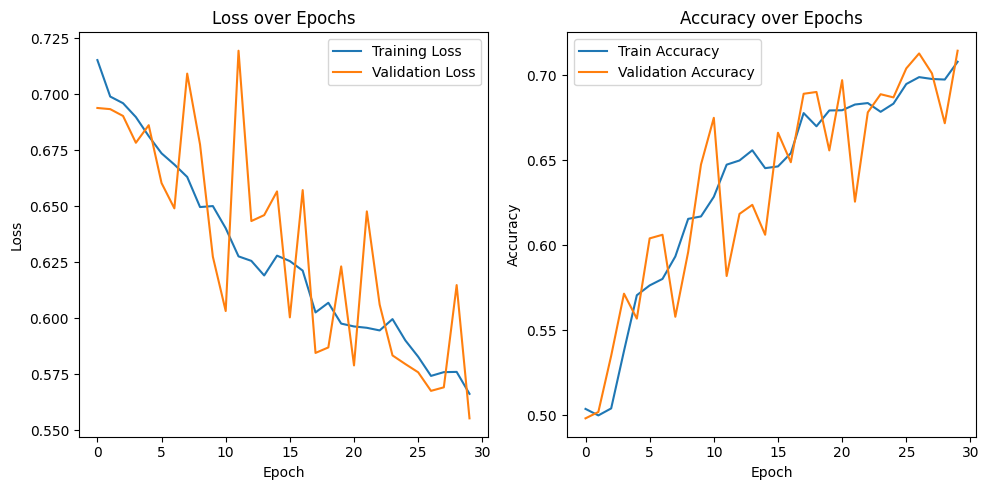

In [11]:
config_path = "/kaggle/input/config4/model.yml"
model=train_model(config_path)

In [ ]:
model.eval()
correct_test = 0
total_test = 0
true_labels=[]
predict_label=[]
predicted_probas=[]
with torch.inference_mode():
    for inputs_test, labels_test in test_loader:
        true_labels.append(labels_test)
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        outputs_test = model(inputs_test)
        probas = nn.functional.softmax(outputs_test, dim=1)
        predicted_probas.append(probas)
        _, predicted_test = torch.max(probas.data, 1)
        predict_label.append(predicted_test)

In [ ]:
true_labels = torch.cat(true_labels, dim=0)
predict_label= torch.cat(predict_label, dim=0)
predicted_probas= torch.cat(predicted_probas, dim=0)
predict_label=predict_label.to('cpu')
predicted_probas=predicted_probas.to('cpu')

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(cls_name), task='Binary')
confmat_tensor = confmat(preds=predict_label,
                         target=true_labels)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), 
    class_names=cls_name,
    figsize=(10, 7)
);

In [ ]:
from sklearn.metrics import classification_report,roc_curve,auc
print(classification_report(true_labels, predict_label))

In [ ]:
plt.figure(figsize=(10, 7))

fpr, tpr, _ = roc_curve(true_labels, predict_label)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')


plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()